In [3]:
from matplotlib import pyplot as plt
import numpy as np
import random
import csv
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

from solar_module import SolarModule, generate_shading, generate_gaussian
from solar_cell import all_series_bypass, SP_interconnection, TCT_interconnection
from string_to_embedding import string_to_embedding, super_to_embedding

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [149]:
class Model(nn.Module):
    def __init__(self, imgchannels=1, fdim=8, zdim=32, mdim=4096, kern=3, imgshape=(3,3), stride=1, pad=1):
        
        super(Model, self).__init__()
        
        # First 2D convolutional layer, taking in 1 input channel (image),
        # outputting 8 convolutional features, with a square kernel size of 2
        self.conv1 = nn.Conv2d(imgchannels, fdim, kern, stride, pad) # (1, 8, 3, 1)

        # Second 2D convolutional layer, taking in the 8 input layers,
        # outputting 32 convolutional features, with a square kernel size of 2
        self.conv2 = nn.Conv2d(fdim, zdim, kern, stride, pad) # (8, 32, 3, 1, 1)

        # Designed to ensure that adjacent pixels are either all 0s or all active
        # with an input probability
        #self.dropout1 = nn.Dropout2d(0.25)
        #self.dropout2 = nn.Dropout2d(0.5)
        
        ldim = zdim*imgshape[0]*imgshape[1]
        self.ldim = ldim

        # First fully connected layer
        self.fc1 = nn.Linear(ldim, mdim) #add a middle linear layer, with size 
        self.fc3 = nn.Linear(mdim, mdim)
        outdim = (imgshape[0]*imgshape[1])**2*3+imgshape[0]*imgshape[1]*2
        #outdim = (imgshape[0]*imgshape[1])**2*3
        self.fc2 = nn.Linear(mdim, outdim)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        
        #x = self.dropout1(x)
        x = x.view(-1, self.ldim)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        #x = self.dropout2(x)
        x = self.fc2(x)
        
        x = F.relu(x)
        #x = x.bool()
        
        return x

model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu


[array([[0.16862687, 1.03328663],
       [1.03328663, 7.45200809]]), array([[1.49069147, 0.        ],
       [0.        , 1.62234351]]), array([[1.03696216, 0.        ],
       [0.        , 1.49211028]]), array([[1.44511194, 0.        ],
       [0.        , 1.01493235]]), array([[1.40126132, 1.2033444 ],
       [1.2033444 , 1.0439196 ]]), array([[1.53743549, 0.        ],
       [0.        , 1.32828269]]), array([[0.99070322, 2.01004356],
       [2.01004356, 4.56762254]]), array([[0.47128553, 0.        ],
       [0.        , 0.84158601]]), array([[1.97173433, 0.55438609],
       [0.55438609, 0.169663  ]]), array([[1.897803  , 0.        ],
       [0.        , 0.34248372]])]


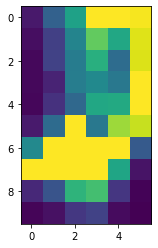

In [150]:
rand_smap = generate_gaussian(10, 10, 6)
plt.imshow(rand_smap)

In [151]:
rand_smap = torch.Tensor(np.expand_dims(rand_smap,0))
print(rand_smap)
print(rand_smap.shape)

tensor([[[ 0.6723,  3.1092,  5.7143, 10.0000, 10.0000,  9.8740],
         [ 0.3782,  1.8908,  4.4958,  7.6050,  6.0084,  9.4958],
         [ 0.2101,  1.9748,  4.2017,  6.3025,  3.5294,  9.4538],
         [ 0.2101,  1.0084,  4.2437,  4.7479,  3.9916, 10.0000],
         [ 0.1681,  1.4286,  3.3613,  6.0084,  6.0924, 10.0000],
         [ 0.7143,  3.4874, 10.0000,  3.9916,  8.5294,  9.1597],
         [ 4.7059, 10.0000, 10.0000, 10.0000, 10.0000,  2.8151],
         [10.0000, 10.0000, 10.0000, 10.0000,  5.8824,  0.5462],
         [ 1.1345,  2.6050,  6.5126,  7.0168,  1.5966,  0.0840],
         [ 0.1261,  0.4622,  1.6387,  1.9748,  0.2941,  0.0000]]])
torch.Size([1, 10, 6])


In [152]:
result = model(rand_smap)
print(result)
print(result.shape)

tensor([[0.0604, 0.0041, 0.0000,  ..., 0.0000, 0.0212, 0.0000]],
       grad_fn=<ReluBackward0>)
torch.Size([1, 10920])


(89, 1797, 3119, 68, 1, 0, 1.0)
389.37747006195303


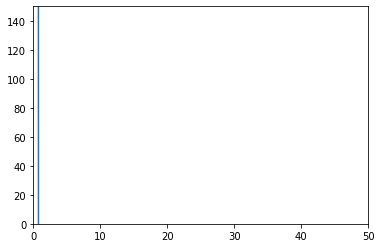

In [153]:
## convert output to embedding using SolarModule object
model.eval()
with torch.no_grad():
    out_data = model(rand_smap)
    #out_data = out_data.type(torch.bool)
    #print(out_data)
    
    out_data = out_data.reshape(10920).cpu().numpy()
    
out_data = np.squeeze(out_data)
embedding, terminal_array = out_data[:10800], out_data[10800:]
embedding = embedding.reshape(10, 6, 10, 6, 3)
terminal_array = terminal_array.reshape(10, 6, 2)
embedding, terminal_array = np.array(embedding, dtype=bool), np.array(terminal_array, dtype=bool)

moduleobj = SolarModule(10,6)
moduleobj.embedding = embedding
moduleobj.terminal_array = terminal_array

print(moduleobj.filter_embedding())
moduleobj.make_netlist()
moduleobj.simulate()
print(moduleobj.MPP)
moduleobj.plot_netlist()

Text(0.5, 1.0, 'Shading Map 8370')

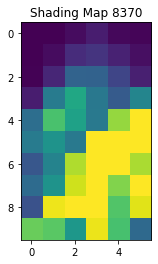

In [16]:
"""Load in Dataset (training_data.csv)"""
read_in = pd.read_csv("shading_series.csv")
def convert_to_array(string):
    a = np.matrix(string).reshape(10, 6)
    a = np.array(a)
    return a
shading_series = [convert_to_array(s) for s in read_in['Shading Maps']]
s = random.randint(0, 10000)
plt.imshow(shading_series[s])
plt.title("Shading Map " + str(s))

In [17]:
read_in = pd.read_csv("embedding_series.csv", header=0, names=['SuperString'], usecols=[1])
configurations = [x for x in read_in['SuperString']]

In [18]:
""" Create dataset data frame """
df = pd.read_csv("training_data.csv",dtype={'MPP':float, 'VMP':float, 'IMP':float, 'VOC':float, 'ISC':float, 'FF':float})
print(df)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
0                    0              0  227.435930   0.67  339.456612   0.75   
1                    0              1   14.058677   3.59    3.916066   3.78   
2                    0              2  179.316049   0.67  267.635894   0.76   
3                    0              3  185.737293   0.67  277.219840   0.76   
4                    0              4  143.931344   0.67  214.822901   0.76   
...                ...            ...         ...    ...         ...    ...   
4217020           4338            198    0.000000  47.48    0.000000  49.96   
4217021           4338            199  163.470000   0.67  243.990000   0.75   
4217022           4338            200  227.600000   0.67  339.700000   0.75   
4217023           4338            201    1.350000  38.81    0.030000  39.03   
4217024           4338            202    0.050000  22.17    0.000000  44.34   

                ISC         FF  
0        353.58787

In [19]:
"""Create Normalised Column"""
normalised = []
for idx, x in enumerate(df['Shading Map #']):
    shading_map = shading_series[x].flatten()
    mpp = df.iloc[idx, 2]
    normalised.append(mpp/sum(shading_map))

In [23]:
print(max(normalised))

0.6449678511000733


In [24]:
df['Normalised MPP'] = normalised
print(df)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
0                    0              0  227.435930   0.67  339.456612   0.75   
1                    0              1   14.058677   3.59    3.916066   3.78   
2                    0              2  179.316049   0.67  267.635894   0.76   
3                    0              3  185.737293   0.67  277.219840   0.76   
4                    0              4  143.931344   0.67  214.822901   0.76   
...                ...            ...         ...    ...         ...    ...   
4217020           4338            198    0.000000  47.48    0.000000  49.96   
4217021           4338            199  163.470000   0.67  243.990000   0.75   
4217022           4338            200  227.600000   0.67  339.700000   0.75   
4217023           4338            201    1.350000  38.81    0.030000  39.03   
4217024           4338            202    0.050000  22.17    0.000000  44.34   

                ISC         FF  Normalised MPP  
0 

In [1134]:
vmp_filtered = df.loc[df['VMP']>3]
vmp_filtered = vmp_filtered.loc[vmp_filtered['IMP']>3]
vmp_filtered = vmp_filtered.loc[df['Normalised MPP']>0.2988]
vmp_filtered = df.sample(100)
print(vmp_filtered)

         Shading Map #  SuperString #         MPP    VMP         IMP    VOC  \
3364821           3463            615   18.870000   0.67   28.170000   0.76   
421724             442            745    0.022513  21.22    0.001061  42.43   
3180724           3274            357   11.450000   2.13    5.380000   2.27   
1145701           1183            596    9.258013   1.38    6.708705   1.52   
3280822           3377            282    0.050000  22.05    0.000000  44.09   
...                ...            ...         ...    ...         ...    ...   
3620677           3725            826    0.040000  18.81    0.000000  37.62   
248060             265            597    0.030584  17.49    0.001749  34.97   
61203               62            508  149.199165   0.67  222.685321   0.76   
3571897           3675            997   11.310000  23.26    0.490000  23.49   
674726             702            945   11.597621   3.61    3.212637   3.79   

                ISC        FF  Normalised MPP  
336

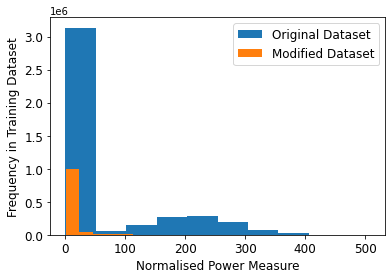

In [827]:
fig, ax = plt.subplots()
ax.hist(df['IMP'], color='C0',bins=10, label = 'Original Dataset')
ax.hist(vmp_filtered['IMP'], color='C1', label = 'Modified Dataset')
ax.set_xlabel('Normalised Power Measure',fontsize='large')
ax.set_ylabel('Frequency in Training Dataset',fontsize='large')
ax.tick_params(axis='both', labelsize='large')
ax.ticklabel_format(style='sci',axis='y', scilimits=(0,0))
ax.legend(fontsize=12)
#ax.set_xlim(0,300)
fig.savefig('histogram.png',dpi=300,bbox_inches="tight")

In [1135]:
""" Create custom dataset """

class CustomDataset(Dataset):
    def __init__(self, df, rotate=None):
        self.df = df
        self.rotate = rotate # for rotation of shading maps?

    def __getitem__(self, index):
        shading_map = self.df.iloc[index, 0]
        shading_map = shading_series[shading_map]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        
        x = self.df.iloc[index, 1]
        x = configurations[x]
        #print(x)
        x = super_to_embedding(10, 6, x) # superstring to boolean embedding
        embedding = x.embedding
        terminal_array = x.terminal_array
        embedding = embedding.flatten()
        terminal_array = terminal_array.flatten()
        
        label = np.append(embedding, terminal_array)
        label = torch.Tensor(label)
        
        power = self.df.iloc[index, -1]
        
        return shading_map, label, power 
        
    def __len__(self):
        return len(self.df['Shading Map #'])
dataset = CustomDataset(vmp_filtered)
print(dataset.__getitem__(2))
print(dataset.__getitem__(2)[0].shape, dataset.__getitem__(2)[1].shape)
print(len(dataset))


(tensor([[[0.0000, 0.5699, 0.3554, 0.6587, 0.2512, 0.1900],
         [0.2757, 1.0000, 1.0000, 0.6036, 0.6587, 0.4718],
         [0.4596, 1.0000, 1.0000, 1.0000, 0.3676, 0.2819],
         [1.0000, 1.0000, 1.0000, 0.3094, 0.3952, 0.5637],
         [1.0000, 0.6464, 0.5116, 0.6985, 0.8456, 1.0000],
         [0.2788, 0.4167, 0.8885, 1.0000, 1.0000, 0.9589],
         [0.1900, 0.5208, 1.0000, 1.0000, 0.7629, 0.4442],
         [0.2665, 0.7475, 0.7935, 0.9344, 0.3983, 0.2420],
         [0.2114, 0.5362, 1.0000, 0.4534, 0.2022, 0.4596],
         [0.1716, 0.7322, 0.4779, 0.2022, 0.4197, 0.0674]]]), tensor([0., 0., 0.,  ..., 1., 0., 1.]), 0.03190166453322557)
torch.Size([1, 10, 6]) torch.Size([10920])
100


In [1129]:
""" Initialize Hyperparameters """
#10,000 iterations, batching of 32

#1e-3 learning rate

# vary each training parameter individually, run multiple experiments. Checkpoint each model, filename w/ parameters

batch_size = 16 # 32-64 is advisable
#learning_rate = 5e-4*batch_size # sensitivity of gradient descent
learning_rate = 1e-4
num_epochs = 167 # iterations over entire dataset 


6
torch.Size([10920])


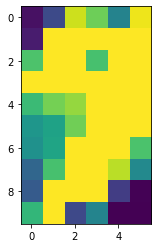

In [1136]:
""" Dataloader """
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)
print(len(train_dataloader))
x, y, p = next(iter(train_dataloader))
img = x[0].squeeze()
embedding = y[0].squeeze()
plt.imshow(img)
print(embedding.shape)

In [1060]:
model = Model(imgshape=(10, 6)).to(device)
print(model)
print(device)

Model(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1920, out_features=4096, bias=True)
  (fc3): Linear(in_features=4096, out_features=4096, bias=True)
  (fc2): Linear(in_features=4096, out_features=10920, bias=True)
)
cpu


In [1131]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [1132]:
ratio_list = []
self_connections = []
conflicting_connections = []
loss_list = []

In [1138]:
# iterate over epochs
entropy_loss = nn.MSELoss(reduction='none')
outfile = 'loss.csv'
cstant = 1e-3
rstant = 0

with open(outfile, 'w', newline='') as f:
    writer = csv.writer(f)
    for epoch in range(num_epochs):

        # iterate over training dataset by batch
        for i, data in enumerate(train_dataloader, 0):

            shading_maps, embeddings, power = data
            shading_maps = shading_maps.to(device)
            result = model(shading_maps)
            """
            result = model(shading_maps)
            for j in range(batch_size):       
                result = model(shading_maps[j,...])[-1]
                label = embeddings[j]
                loss_ += entropy_loss(result.float(), label.float())
                break
            break
            """
            
            average_ratio = 0
            self_c = 0
            conflicting_c = 0
            for j in range(0, batch_size):
                embedding = result[j]
                embedding = np.squeeze(embedding.detach())
                embedding, terminal_array = embedding[:10800], embedding[10800:]
                embedding = embedding.reshape(10, 6, 10, 6, 3)
                terminal_array = terminal_array.reshape(10, 6, 2)
                
                series_connections = torch.count_nonzero(embedding[...,0]) + torch.count_nonzero(embedding[...,1])
                parallel_connections = torch.count_nonzero(embedding[...,2])
                
                if parallel_connections == 0:
                    average_ratio += 0
                elif parallel_connections > 0:
                    average_ratio += (series_connections / parallel_connections)
                
                moduleobj = SolarModule(10, 6)
                moduleobj.embedding = np.array(embedding.numpy(), dtype=bool)
                moduleobj.terminal_array = np.array(terminal_array.numpy(), dtype=bool)
                filtering = moduleobj.filter_embedding()
                self_c += filtering[0]
                conflicting_c += filtering[1]
           
            average_ratio /= batch_size
            self_c /= batch_size
            conflicting_c /= batch_size
            ratio_list.append(float(average_ratio))
            self_connections.append(self_c)
            conflicting_connections.append(conflicting_c)
            
            loss = torch.mean(entropy_loss(result, embeddings),axis=1)
            loss = torch.mean(loss*(1-power))
            conflicting_c = float(conflicting_c)
            average_ratio = float(average_ratio)
            #loss = loss + conflicting_c * cstant
            loss = loss + conflicting_c * cstant + rstant/average_ratio
            
            #TODO: Add SP-Ratio into loss. Can try add self-connection to loss as well (gently)
            #TODO: Redo training loops on new loss function
            
            loss_list.append(float(loss))
            
            writer.writerow([i, loss])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            print(i, ratio_list[-1], self_connections[-1], conflicting_connections[-1], loss)
       
        print('Epoch {}: Loss {}'.format(epoch, loss))

# create validation/evaluation batch of 10 or so shading maps, calculate the power from that
# visualise embeddings or circuit diagram against shading map

# use embeddings generated by superstrings for supervised approach. 
# pre-train on training_data.csv
# binary cross entropy between model and training data

# sort training_data.csv by performance (power)
# train same model by binary cross entropy
# use entire dataset, then use higher performing subset, then a subset of that, etc. 
# label = embedding

0 0.20701651275157928 0.3125 7.125 tensor(0.0616, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.41428259015083313 0.125 2.625 tensor(0.0391, dtype=torch.float64, grad_fn=<AddBackward0>)
2 2.151718854904175 0.1875 2.0625 tensor(0.0444, dtype=torch.float64, grad_fn=<AddBackward0>)
3 1.6862294673919678 0.125 1.8125 tensor(0.0630, dtype=torch.float64, grad_fn=<AddBackward0>)
4 1.675251841545105 0.3125 1.5625 tensor(0.0548, dtype=torch.float64, grad_fn=<AddBackward0>)
5 1.4434055089950562 0.125 1.0625 tensor(0.0674, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 0: Loss 0.06741177100271308
0 0.9162275791168213 0.0625 0.6875 tensor(0.0417, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.4419623911380768 0.0 0.125 tensor(0.0525, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.29898643493652344 0.0 0.1875 tensor(0.0575, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.3438832461833954 0.375 0.0625 tensor(0.0408, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.233801931142807 0.0625 0

5 0.08183892071247101 1.3125 6.4375 tensor(0.0653, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 13: Loss 0.06534211551894697
0 0.08359455317258835 0.625 2.9375 tensor(0.0351, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.07095537334680557 0.5 7.75 tensor(0.0428, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.11863768845796585 0.9375 7.5625 tensor(0.0682, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.14752249419689178 0.6875 9.0625 tensor(0.0591, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.1517300009727478 1.8125 12.0625 tensor(0.0627, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.1269017457962036 1.5 9.125 tensor(0.0527, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 14: Loss 0.05265495918296819
0 0.06841034442186356 0.75 11.5 tensor(0.0516, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.04211803898215294 0.375 9.0 tensor(0.0474, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.06444918364286423 1.0 12.875 tensor(0.0631, dtype=torch.float64, grad_fn=<AddBack

3 0.051680710166692734 0.0625 3.875 tensor(0.0403, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.016919929534196854 0.0 3.5625 tensor(0.0410, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.020842814818024635 0.25 3.3125 tensor(0.0288, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 27: Loss 0.028783435227548355
0 0.01876545511186123 0.0625 4.125 tensor(0.0364, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.0488969087600708 0.0 3.125 tensor(0.0279, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.03720631077885628 0.0 2.625 tensor(0.0377, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.057454586029052734 0.0625 1.6875 tensor(0.0285, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.053893011063337326 0.125 2.0625 tensor(0.0279, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.07443814724683762 0.0 2.625 tensor(0.0312, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 28: Loss 0.031231340013394254
0 0.03806488960981369 0.0 1.8125 tensor(0.0328, dtype=torch.float64, grad_fn=<Ad

1 0.027261484414339066 0.0625 0.875 tensor(0.0314, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.0753592699766159 0.1875 1.5 tensor(0.0246, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.055016081780195236 0.125 0.8125 tensor(0.0284, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.06096004694700241 0.0 0.8125 tensor(0.0302, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.05545718967914581 0.1875 1.375 tensor(0.0257, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 41: Loss 0.025727315087787257
0 0.02009526640176773 0.0625 0.9375 tensor(0.0267, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.0357862263917923 0.0 0.6875 tensor(0.0232, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.039440084248781204 0.0625 0.9375 tensor(0.0258, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.037179067730903625 0.0625 1.1875 tensor(0.0271, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.06942716240882874 0.125 0.8125 tensor(0.0353, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.07173723727

0 0.03982432186603546 0.0 0.9375 tensor(0.0363, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.05441606044769287 0.0 0.1875 tensor(0.0218, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.0502198189496994 0.0 0.1875 tensor(0.0192, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.04163035750389099 0.0 0.25 tensor(0.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.03536053001880646 0.0625 0.25 tensor(0.0283, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.030683649703860283 0.0625 0.6875 tensor(0.0259, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 55: Loss 0.025862692630631297
0 0.10297250002622604 0.0625 0.375 tensor(0.0312, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.10472062230110168 0.0625 0.3125 tensor(0.0260, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.09992781281471252 0.0625 0.25 tensor(0.0197, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.05651828646659851 0.0625 0.1875 tensor(0.0242, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.021406985819339752 

0 0.11888112127780914 0.0 0.25 tensor(0.0265, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.25775015354156494 0.0625 0.25 tensor(0.0253, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.09752477705478668 0.0 0.25 tensor(0.0315, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.1154644787311554 0.0 0.3125 tensor(0.0245, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.0379205122590065 0.0 0.5625 tensor(0.0220, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.02968255802989006 0.0 0.25 tensor(0.0181, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 69: Loss 0.01812928435018325
0 0.03209318965673447 0.0625 0.5 tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.032747782766819 0.0 0.875 tensor(0.0330, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.15779586136341095 0.0 0.25 tensor(0.0208, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.07038802653551102 0.0625 0.375 tensor(0.0243, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.12566784024238586 0.0 0.3125 tensor(0.021

0 0.0601312592625618 0.0 0.25 tensor(0.0328, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.09295063465833664 0.0 0.0625 tensor(0.0229, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.11732885986566544 0.0 0.3125 tensor(0.0263, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.06317118555307388 0.0 0.125 tensor(0.0190, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.03642354533076286 0.0 0.1875 tensor(0.0248, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.07469642162322998 0.0 0.25 tensor(0.0210, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 83: Loss 0.020995536578143625
0 0.06293343752622604 0.0 0.0625 tensor(0.0191, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.0757363885641098 0.0 0.0625 tensor(0.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.11285695433616638 0.0 0.1875 tensor(0.0224, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.03712762892246246 0.0 0.125 tensor(0.0292, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.055985141545534134 0.0 0.3125 tensor(0

0 0.06110933795571327 0.0 0.125 tensor(0.0204, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.06226833164691925 0.0 0.1875 tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.07028356939554214 0.0 0.25 tensor(0.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.09867921471595764 0.0 0.0 tensor(0.0242, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.09590236842632294 0.0 0.125 tensor(0.0279, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.06629394739866257 0.0 0.25 tensor(0.0283, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 97: Loss 0.028256667369300985
0 0.08427386730909348 0.0 0.0625 tensor(0.0261, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.11258150637149811 0.0 0.0625 tensor(0.0202, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.12074878066778183 0.0 0.25 tensor(0.0259, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.13719542324543 0.0 0.0625 tensor(0.0272, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.28850096464157104 0.0 0.0 tensor(0.0276, dty

0 0.08606304228305817 0.0 0.3125 tensor(0.0218, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.09494359791278839 0.0 0.1875 tensor(0.0240, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.09253495931625366 0.0 0.0 tensor(0.0223, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.06805858761072159 0.0 0.125 tensor(0.0215, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.0593150295317173 0.0 0.0 tensor(0.0250, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.1724739968776703 0.0 0.0 tensor(0.0237, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 111: Loss 0.02374855659568928
0 0.15041838586330414 0.0 0.0625 tensor(0.0256, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.07496478408575058 0.0 0.0 tensor(0.0307, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.24031944572925568 0.0 0.125 tensor(0.0219, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.25496146082878113 0.0 0.0 tensor(0.0223, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.14167271554470062 0.0 0.0 tensor(0.0201, dtype=to

0 0.21034455299377441 0.0 0.125 tensor(0.0273, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.16622772812843323 0.0 0.0 tensor(0.0207, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.284109890460968 0.0 0.0 tensor(0.0274, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.32964712381362915 0.0 0.0625 tensor(0.0262, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.17256182432174683 0.0 0.0625 tensor(0.0211, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.13977769017219543 0.0 0.0625 tensor(0.0211, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 125: Loss 0.021125729626999067
0 0.09394592046737671 0.0 0.0625 tensor(0.0207, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.08123382925987244 0.0 0.125 tensor(0.0202, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.06185095012187958 0.0 0.25 tensor(0.0245, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.08057388663291931 0.0 0.25 tensor(0.0236, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.07455424964427948 0.0 0.0625 tensor(0.0284,

0 0.08753606677055359 0.0 0.0625 tensor(0.0266, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.36642956733703613 0.0 0.125 tensor(0.0221, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.062200240790843964 0.0 0.0 tensor(0.0287, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.05640052258968353 0.0 0.0 tensor(0.0239, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.14007525146007538 0.0 0.1875 tensor(0.0243, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.07400109618902206 0.0 0.0 tensor(0.0213, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 139: Loss 0.021259634778779304
0 0.18191832304000854 0.0 0.0 tensor(0.0225, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.17002339661121368 0.0 0.0 tensor(0.0256, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.65766441822052 0.0 0.0 tensor(0.0234, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.46734878420829773 0.0 0.0625 tensor(0.0209, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.3610350787639618 0.0 0.0 tensor(0.0211, dtype=torc

1 0.04339095205068588 0.0 0.1875 tensor(0.0250, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.03265506029129028 0.0 0.0 tensor(0.0264, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.12887907028198242 0.0 0.125 tensor(0.0247, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.16209156811237335 0.0 0.0 tensor(0.0185, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.49456241726875305 0.0 0.125 tensor(0.0253, dtype=torch.float64, grad_fn=<AddBackward0>)
Epoch 153: Loss 0.025326377735565512
0 0.21571148931980133 0.0 0.0 tensor(0.0272, dtype=torch.float64, grad_fn=<AddBackward0>)
1 0.6041712760925293 0.0 0.0 tensor(0.0254, dtype=torch.float64, grad_fn=<AddBackward0>)
2 0.24645598232746124 0.0 0.125 tensor(0.0234, dtype=torch.float64, grad_fn=<AddBackward0>)
3 0.6142511963844299 0.0 0.0 tensor(0.0192, dtype=torch.float64, grad_fn=<AddBackward0>)
4 0.06902431696653366 0.0 0.0 tensor(0.0273, dtype=torch.float64, grad_fn=<AddBackward0>)
5 0.20251062512397766 0.0 0.1875 tensor(0.0227, dtype=to

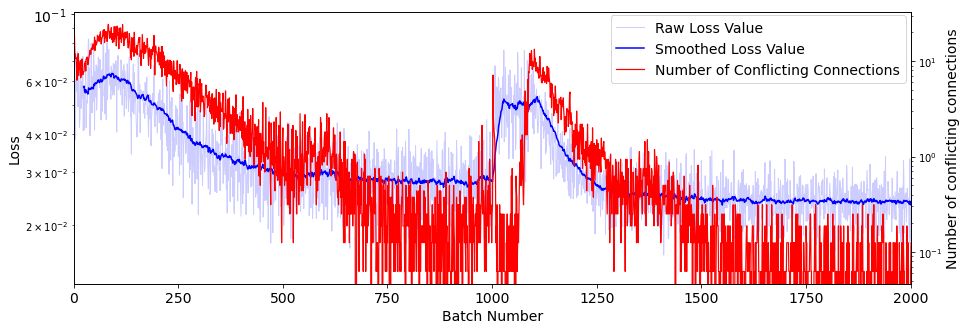

In [1140]:
fig, ax1 = plt.subplots(figsize=(15,5))

window_size = 25
smoothed = pd.Series(loss_list).rolling(window_size).mean().tolist()

ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax1.plot(loss_list,linewidth=1,alpha=0.2,color='blue',label='Raw Loss Value')
ax1.plot(smoothed, linewidth=1.5,alpha=1,color='blue',label='Smoothed Loss Value')
ax1.set_xlabel('Batch Number',fontsize=14)
ax1.set_ylabel('Loss',fontsize=14)
#ax1.set_ylabel('SP Ratio')
ax1.set_xlim(0, 2000)
#ax1.set_ylim(0.01,1)
ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.set_yscale('log')
#ax2.set_ylim(1,10000)
ax2.set_ylabel('Number of conflicting connections',fontsize=14)
ax2.plot(conflicting_connections,linewidth=1.2,color='red',label='Number of Conflicting Connections')
fig.legend(loc='upper right', bbox_to_anchor=(0.902,0.89),fontsize=14)
plt.savefig('training_graph.png',dpi=300,bbox_inches="tight")

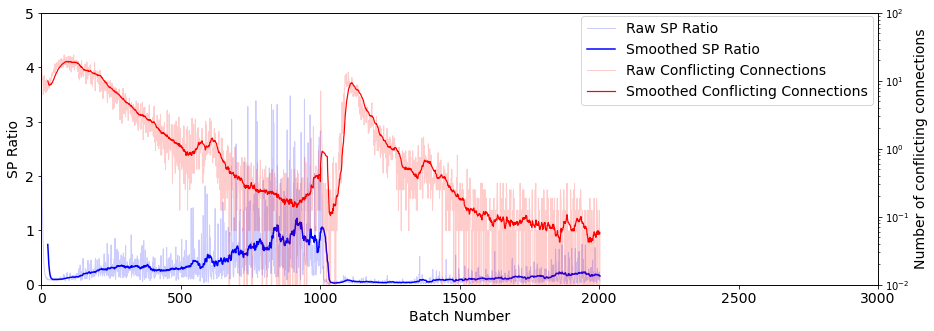

In [1141]:
fig, ax1 = plt.subplots(figsize=(15,5))

window_size = 25
smoothed = pd.Series(ratio_list).rolling(window_size).mean().tolist()
smoothed1 = pd.Series(conflicting_connections).rolling(window_size).mean().tolist()

ax1.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='both', labelsize=14)

ax1.plot(ratio_list,linewidth=1,alpha=0.2,color='blue',label='Raw SP Ratio')
ax1.plot(smoothed, linewidth=1.5,alpha=1,color='blue',label='Smoothed SP Ratio')
ax1.set_xlabel('Batch Number',fontsize=14)
ax1.set_ylabel('SP Ratio',fontsize=14)
ax1.set_xlim(0, 3000)
ax1.set_ylim(0,5)
#ax1.set_yscale('log')
ax2 = ax1.twinx()
ax2.set_yscale('log')
ax2.set_ylim(0.01,100)
ax2.set_ylabel('Number of conflicting connections',fontsize=14)
ax2.plot(conflicting_connections,linewidth=1,alpha=0.2,color='red',label='Raw Conflicting Connections')
ax2.plot(smoothed1,linewidth=1.2,color='red',label='Smoothed Conflicting Connections')
fig.legend(loc='upper right', bbox_to_anchor=(0.902,0.89),fontsize=14)
plt.savefig('training_graph.png',dpi=300,bbox_inches="tight")

In [1143]:
""" Save training lists to csv file """
list_df = [ratio_list, self_connections, conflicting_connections, loss_list]
list_df = pd.DataFrame(list_df).transpose()
list_df.to_csv('training_metrics.csv', header=['S-P Ratio', 'Self Connections', 'Conflicting Connections', 'Loss'])

In [1144]:
''' save model checkpoint '''
# set model checkpoint path inc. hyperparams
_path = 'model.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, _path)

In [1145]:
""" load model checkpoint """
''' load model checkpoint from file '''

# init model and optimiser
#model = TheModelClass(*args, **kwargs)
#optimizer = TheOptimizerClass(*args, **kwargs)

#_path = '../data/model/cnn-vae-f16-k5-z128-i121-v01.pth'
#_path = '../data/model/cnn-vae-f16-k3-z128-i115-v01.pth'
_path = 'model.pth'

# load checkpoint
checkpoint = torch.load(_path)

# update model
#model.load_state_dict(checkpoint['model_state_dict'])
model.load_state_dict(checkpoint['model_state_dict'])

# update optimiser
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# set epoch and loss
epoch = checkpoint['epoch']
loss = checkpoint['loss']

# set model train/eval state
#model.eval()
#model.train()

In [ ]:
""" Model evaluation creation - DO NOT RUN"""
evaluation_shading_maps = pd.Series([generate_gaussian(10, 10, 6) for x in range(0, 100)])
print(evaluation_shading_maps)
filename = 'evaluation_series.csv'
with open(filename, 'w', newline='') as f:
    evaluation_shading_maps.to_csv(f, header=["Shading Maps"])

In [1065]:
""" Load in evaluation series"""
read_in = pd.read_csv("evaluation_series.csv", header=0, names=['Shading Maps'], usecols=[1])
eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [1146]:
class EvalDataset(Dataset):
    def __init__(self, series):
        self.series = series
    def __getitem__(self, index):
        shading_map = self.series[index]
        #print(shading_map)
        shading_map = torch.Tensor(shading_map)/10
        shading_map = shading_map.unsqueeze(0)
        return shading_map
    def __len__(self):
        return len(self.series)
evaldataset = EvalDataset(eval_series)
test_loader = torch.utils.data.DataLoader(evaldataset, batch_size=1)

In [1147]:
embedding_list = []
terminal_list = []
voltage_list = []
current_list = []
power_list = []
normal_list = []

In [1148]:
''' evaluate model & visualise outputs'''
model.eval()
with torch.no_grad():
    # get single random image batch from test dataset
    for i, s in enumerate(test_loader, 0):
        
        # push images to gpu
        shading_map = s.to(device)
        # plot input image
        #plt.figure()
        # compute output image
        result = model(shading_map)
        #print(result)
        # get output image from gpu, reshape
        
        result = np.squeeze(result).cpu().numpy()
        embedding, terminal_array = result[:10800], result[10800:]
        embedding = embedding.reshape(10, 6, 10, 6, 3)
        embedding = np.array(embedding, dtype=bool)
        
        embedding_list.append(np.copy(embedding)) # copy is required as filter_embedding() modifies both the embedding
                                                  # and the terminal array
        
        terminal_array = terminal_array.reshape(10, 6, 2)
        terminal_array = np.array(terminal_array, dtype=bool)
        
        terminal_list.append(np.copy(terminal_array))
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = embedding
        moduleobj.terminal_array = terminal_array
        moduleobj.shading_map = np.squeeze(shading_map).cpu().numpy()*10
        denominator = sum(moduleobj.shading_map.flatten())
        
        try:
            moduleobj.make_netlist()
            moduleobj.simulate()
            voltage_list.append(moduleobj.VMP)
            current_list.append(moduleobj.IMP)
            power_list.append(moduleobj.MPP)
            normal_list.append(moduleobj.MPP/denominator)
            print("{} {} W {} V {} A".format(moduleobj.MPP/denominator, moduleobj.MPP, moduleobj.VMP, moduleobj.IMP))
        except:
            filtering = moduleobj.filter_embedding()
            print('filtered ',end='')
            self_c += filtering[0]
            conflicting_c += filtering[1]
            #if filtering[0] <= 0 and filtering[1] <= 5:
            try:
                moduleobj.make_netlist()
                moduleobj.simulate();
                voltage_list.append(moduleobj.VMP)
                current_list.append(moduleobj.IMP)
                power_list.append(moduleobj.MPP)
                normal_list.append(moduleobj.MPP/denominator)
                print("{} {} W {} V {} A".format(moduleobj.MPP/denominator, moduleobj.MPP, moduleobj.VMP, moduleobj.IMP))
            except:
                voltage_list.append(0)
                current_list.append(0)
                power_list.append(0)
                normal_list.append(0)

filtered 0.6364424311270044 191.70788369616125 W 0.6600000000000004 V 290.466490448729 A
filtered 0.6390512047800464 222.79302992103533 W 0.6600000000000004 V 337.5651968500533 A
filtered 0.6058553412145071 189.99188017639153 W 0.6600000000000004 V 287.8664851157446 A
0.5779657412269201 182.41084568674773 W 0.6600000000000004 V 276.3800692223449 A
filtered 0.5910910820010941 193.08434061862846 W 0.6600000000000004 V 292.55203124034597 A
0.6387902444133435 294.60341208278726 W 0.6700000000000004 V 439.7065851981897 A
filtered 0.6256005579134468 143.73601901917783 W 0.6600000000000004 V 217.7818469987542 A
filtered 0.6241336284525402 220.59103283451694 W 0.6600000000000004 V 334.22883762805577 A
filtered 0.6324605875791055 157.04448963089126 W 0.6600000000000004 V 237.9461964104412 A
filtered 0.4965706570996274 160.76873765266748 W 0.6600000000000004 V 243.58899644343546 A
filtered 0.5666673753751094 206.76186166388882 W 0.6700000000000004 V 308.5997935281921 A
filtered 0.591565501380020

/Users/mlima/Documents/GitHub/reconfig-bipv/solar_module.py:308: RuntimeWarning: invalid value encountered in double_scalars
  self.FF = self.MPP/(self.VOC * self.ISC)


filtered 0.43381392225370974 143.03724859497808 W 0.6600000000000004 V 216.72310393178486 A
filtered 0.45715404988968256 104.80275458542025 W 0.6500000000000004 V 161.2350070544926 A
filtered 0.6125405313745075 230.8540921069739 W 0.6700000000000004 V 344.55834642831906 A
filtered 0.5741343329650622 196.69487378791757 W 0.6600000000000004 V 298.0225360422992 A
filtered 0.6352405165693086 179.68517059517845 W 0.6600000000000004 V 272.25025847754296 A
filtered 0.6384148440785223 214.07530326549238 W 0.6600000000000004 V 324.3565200992307 A
filtered 0.622550027606894 228.71265050030456 W 0.6700000000000004 V 341.3621649258275 A
filtered 0.30172395145549236 139.64613471049717 W 0.6700000000000004 V 208.42706673208522 A
filtered 0.6026949190912646 239.15192344639055 W 0.6700000000000004 V 356.9431693229708 A
0.6286813340838877 195.98037723255587 W 0.6600000000000004 V 296.9399655038724 A
filtered 0.613532838404888 140.50088710749907 W 0.6600000000000004 V 212.8801319810591 A
filtered 0.6201

In [1069]:
np.mean(normal_list), np.mean(voltage_list), np.mean(current_list)

(0.0839998979861838, 0.5547000000000003, 39.93234089698784)

In [1072]:
print(np.var(embedding_list))
l = [x.flatten() for x in embedding_list]
for x in range(len(embedding_list) - 1):
    print(x, all(embedding_list[x].flatten() == embedding_list[x+1].flatten()),\
          all(terminal_list[x].flatten() == terminal_list[x+1].flatten()))

0.03813669591820988
0 False False
1 False False
2 False False
3 False False
4 False False
5 False False
6 False False
7 False False
8 False False
9 False False
10 False False
11 False False
12 False False
13 False False
14 False False
15 False False
16 False False
17 False False
18 False False
19 False False
20 False False
21 False False
22 False False
23 False False
24 False False
25 False False
26 False False
27 False False
28 False False
29 False False
30 False False
31 False False
32 False False
33 False False
34 False False
35 False False
36 False False
37 False False
38 False False
39 False False
40 False False
41 False False
42 False False
43 False False
44 False False
45 False False
46 False False
47 False False
48 False False
49 False False
50 False False
51 False False
52 False False
53 False False
54 False False
55 False False
56 False False
57 False False
58 False False
59 False False
60 False False
61 False False
62 False False
63 False False
64 False False
65 False False


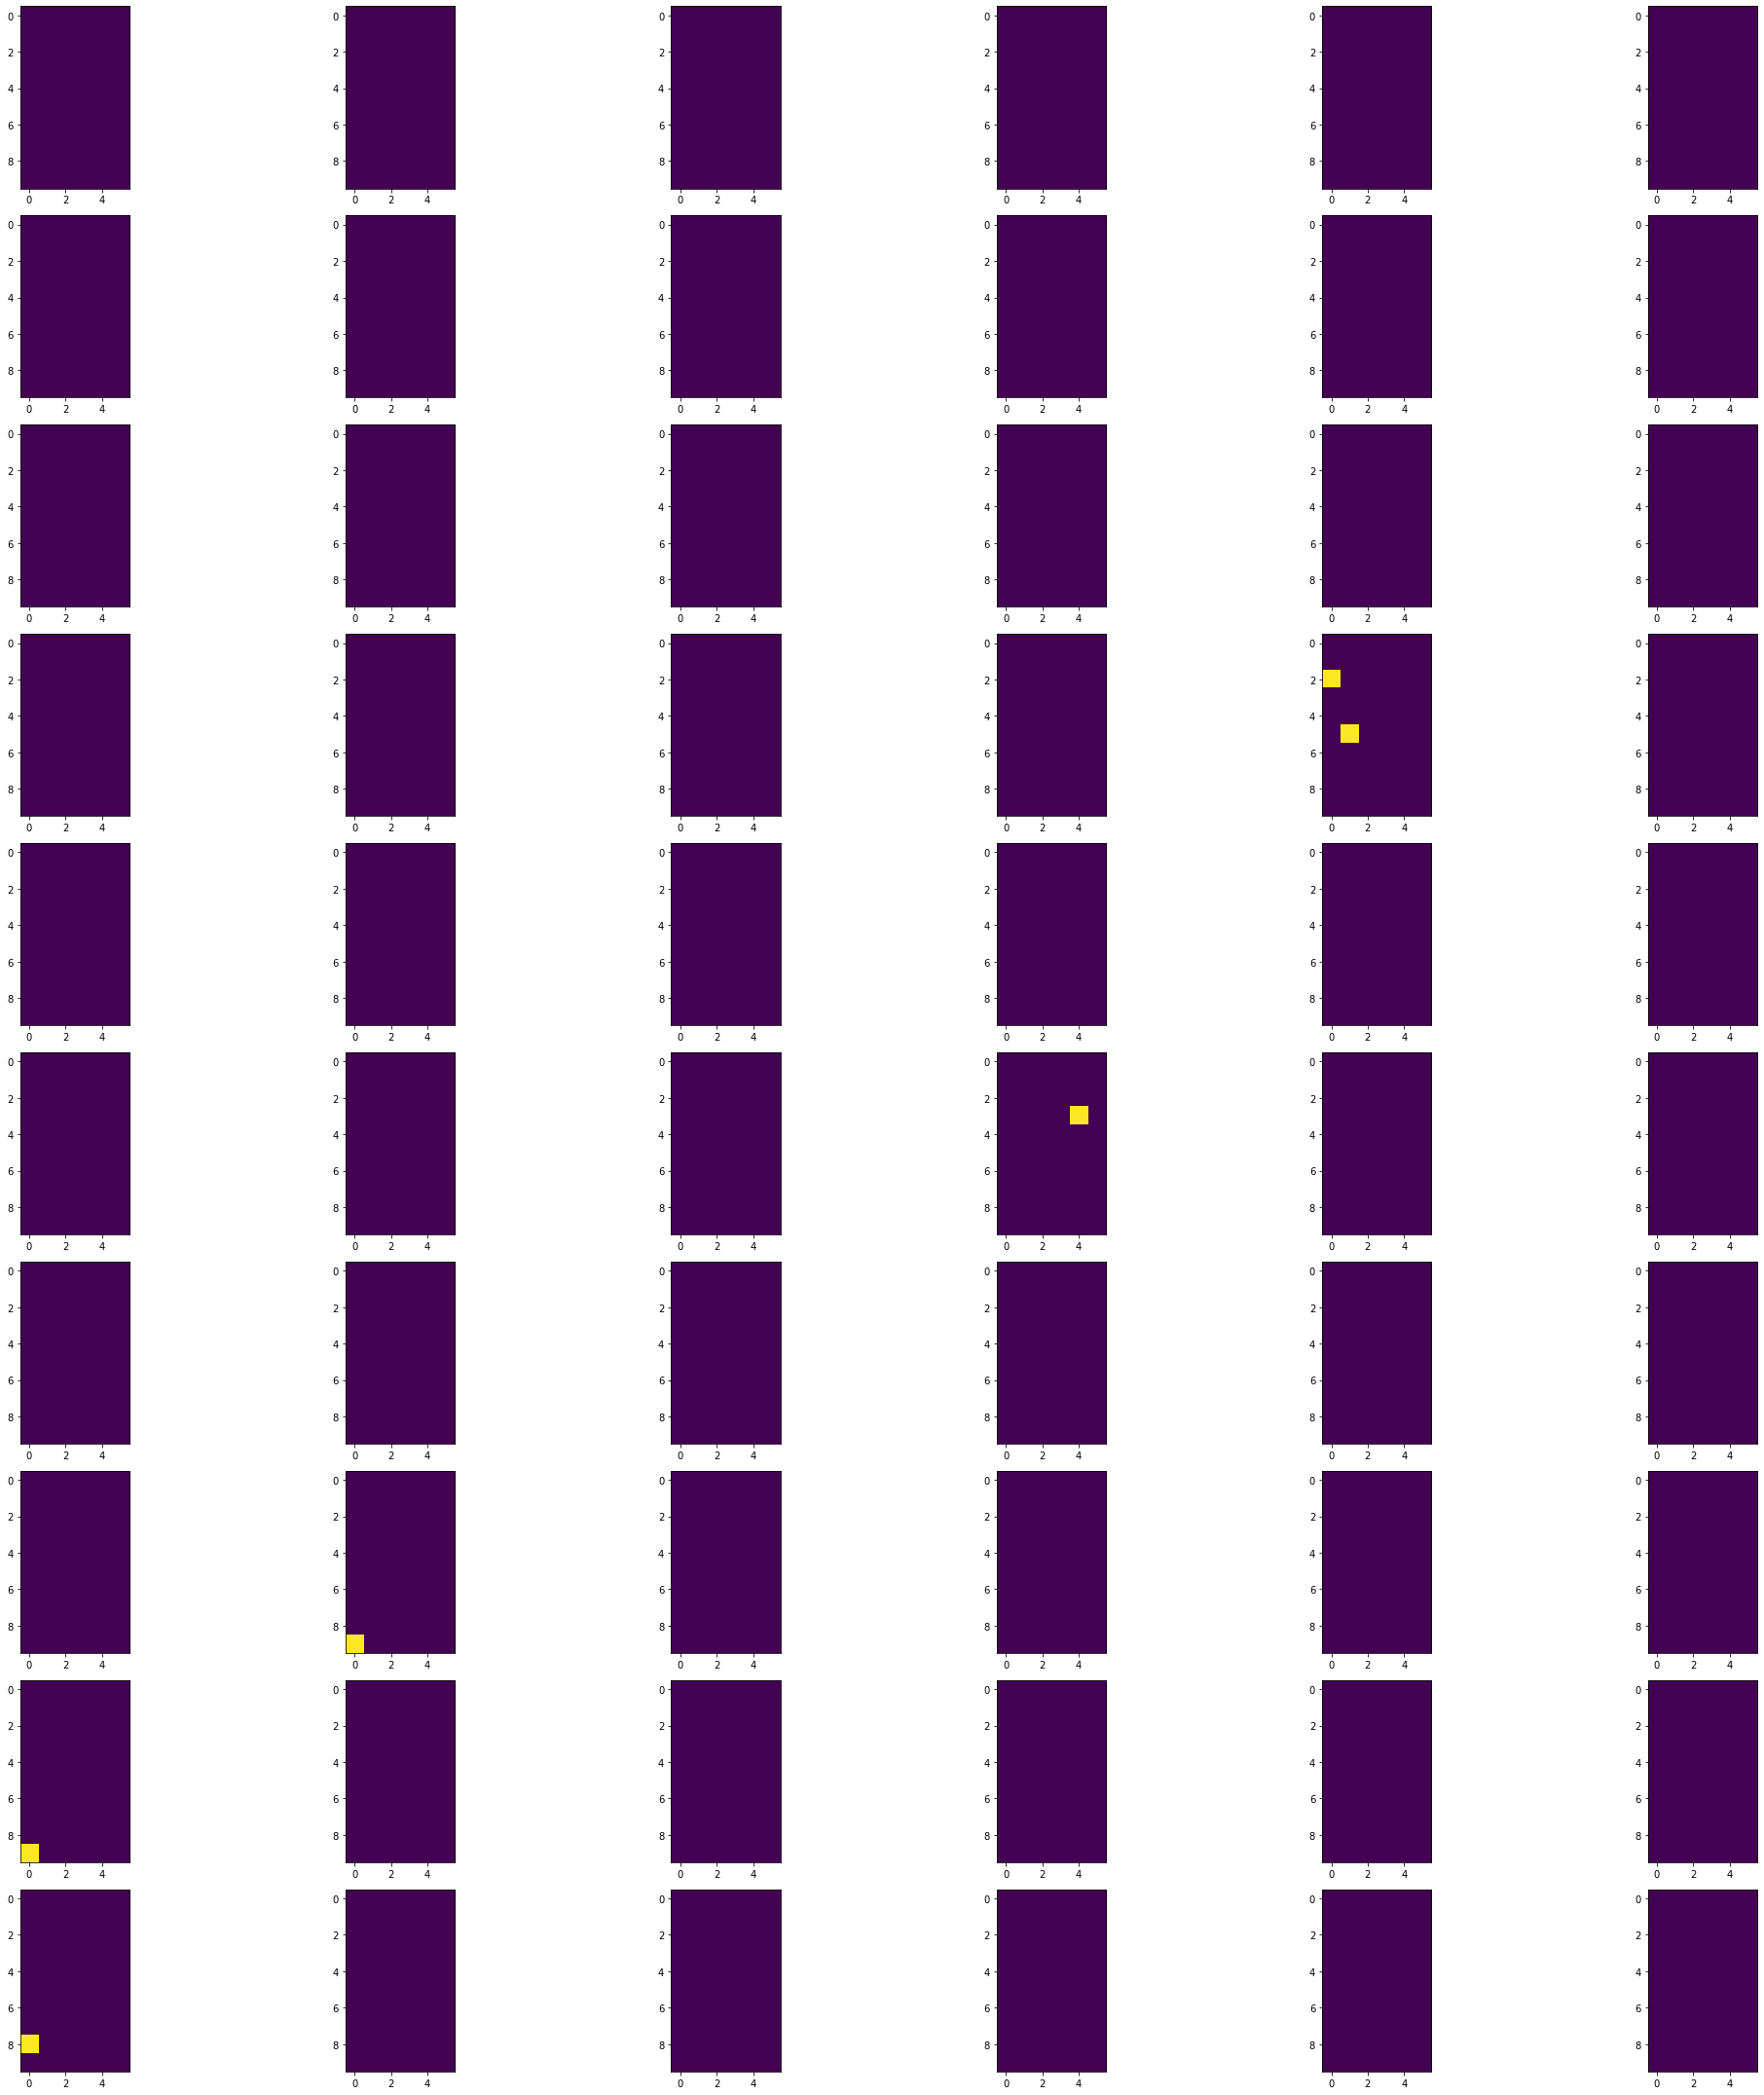

In [1098]:
fig, axs = plt.subplots(nrows=10,ncols=6, figsize=(30,30))

for i in range(6):
    for j in range(10):
        axs[j,i].imshow(embedding_list[1][j,i,...,2])
plt.tight_layout()

In [ ]:
# comparing evaluation embeddings predicted by model to 1000 embeddings in dataset.
thousand_modules = [super_to_embedding(10, 6, x) for x in configurations]
benchmark = [np.append(x.embedding.flatten(), x.terminal_array.flatten()) for x in thousand_modules]
print(benchmark[0].shape)    
comparison = [np.append(embedding_list[x].flatten(), terminal_list[x].flatten()) for x in range(0, len(embedding_list))]
print(len(comparison))
print(len(comparison[0]))

difference_list = []
for model_output in comparison:
    difference = []
    for array in benchmark:
        value = sum(model_output ^ array)
        print(value)
        difference.append(value)
    difference_list.append(difference)

In [ ]:
for x in difference_list:
    print(x.index(min(x)), end=' ')

In [ ]:
print(min(x))

In [ ]:
r, c = 2,0
plt.imshow(embedding_list[0][r,c,...,2])
plt.figure()
plt.imshow(embedding_list[34][r,c,...,2])
plt.figure()
plt.imshow(embedding_list[72][r,c,...,2])

In [ ]:
fig, ax = plt.subplots()
ax.hist(p_list, color='C1')
ax.set_xlabel('Maximum Power (W)',fontsize='large')
ax.set_ylabel('Frequency in Evaluation Dataset',fontsize='large')
ax.tick_params(axis='both', labelsize='large')
ax.set_xlim(0,300)
fig.savefig('histogram.png',dpi=300,bbox_inches="tight")

In [ ]:
''' save model checkpoint '''

# set model checkpoint path inc. hyperparams
_path = 'Checkpoints/Batch42FromInit.pth'
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
}, _path)


In [ ]:
new_eval_shading_maps = pd.Series([generate_gaussian(10, 10, 6) for x in range(0, 100)])
#print(new_eval_shading_maps)
filename = 'new_eval_shading_maps.csv'
with open(filename, 'w', newline='') as f:
    new_eval_shading_maps.to_csv(f, header=["Shading Maps"])
read_in = pd.read_csv("new_eval_shading_maps.csv", header=0, names=['Shading Maps'], usecols=[1])
new_eval_series = [convert_to_array(s) for s in read_in['Shading Maps']]

In [ ]:
filename = 'conflict4-no351_embedding_simulations.csv'
with open(filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['Embedding No.', 'Map No.', 'Normalised Power', 'MPP', 'VMP', 'IMP', 'Filtered Embedding?'])
    for embedding_no, embedding in enumerate(embedding_list):
        
        terminal_array = terminal_list[embedding_no] # get corresponding terminal array for embedding
        
        moduleobj = SolarModule(10,6)
        moduleobj.embedding = np.copy(embedding)
        moduleobj.terminal_array = np.copy(terminal_array)
        
        try:
            moduleobj.make_netlist()
            modified = False
        except ValueError:
            moduleobj.filter_embedding()
            moduleobj.make_netlist()
            modified = True
        
        for map_no, shading_map in enumerate(new_eval_series):
            moduleobj.shading_map = shading_map
            denominator = sum(moduleobj.shading_map.flatten())
            moduleobj.make_netlist()
            moduleobj.simulate()
            normal_power = moduleobj.MPP/denominator
            print("embedding {}, shading map {}, {} %, {} W, {} V, {} A, modified {}".format(embedding_no, map_no, \
                                            round(normal_power, 2), round(moduleobj.MPP, 2), \
                                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2), modified))
            writer.writerow([embedding_no, map_no, round(normal_power, 2), round(moduleobj.MPP, 2), \
                            round(moduleobj.VMP, 2), round(moduleobj.IMP, 2), modified])